In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D


from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [3]:
sns.set_style("darkgrid")
sns.set_context("talk")

from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [4]:
SYNTHETIC_DATASETS = ["gestalt_shapegen", "tdw", "hypersim_v2", "hypersim_v3"]

In [77]:
projName = "mlve"
dataset = "tdw"
experimentName = f"{dataset}-depth-estimation-pilot"
S3_BUCKET_NAME = "mlve-v1"
iterName = "v2-all"

In [78]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

def results_to_df(max_limit=-1):
    results = []
    cursor = col.find({})
    count = 0
    for document in cursor:
        results.append(document)
        count += 1
        if max_limit > -1 and count == max_limit:
            break
    
    print(f"Returning {count} total records" )
    df = pd.DataFrame(results)
    return df

df = results_to_df()

Checking database connection...
Connection established!
Returning 4105 total records


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105 entries, 0 to 4104
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               4105 non-null   object 
 1   imageMetadata     3896 non-null   object 
 2   imageURL          4075 non-null   object 
 3   attentionCheck    4075 non-null   object 
 4   gtDepths          3896 non-null   object 
 5   correctChoice     4075 non-null   float64
 6   probeLocations    4075 non-null   object 
 7   isDuplicate       4075 non-null   object 
 8   batchIdx          4075 non-null   float64
 9   rt                4105 non-null   int64  
 10  index             4075 non-null   float64
 11  stimulus          4075 non-null   object 
 12  response          4105 non-null   object 
 13  correct           4075 non-null   object 
 14  probe_locations   4075 non-null   object 
 15  correct_choice    4075 non-null   float64
 16  choices           4075 non-null   object 


In [80]:
mean_response_time = df.groupby("userID")["rt"].sum().mean() / 1000 / 60 # mean response time in minutes for full experimen
response_time_std = df.groupby("userID")["rt"].sum().std() / 1000 / 60

In [81]:
response_time_std

4.848179272518199

In [82]:
mean_response_time

9.377863333333334

In [83]:
mean_response_time - response_time_std * 2

-0.3184952117030644

In [84]:
df.groupby("userID")["rt"].sum().max() / 1000 / 60 # mean response time in minutes for full experimen


23.706166666666665

In [85]:
testdf = df[~df["correct"].isna()]

In [86]:
testdf = df[~df["correct"].isna()]
duplicate_key = [x for x in df.columns if "duplicate" in x.lower()][0]
print(duplicate_key)
testdf = df[df[duplicate_key] == False]
testdf.info()

isDuplicate
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177 entries, 0 to 4103
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               3177 non-null   object 
 1   imageMetadata     2998 non-null   object 
 2   imageURL          3177 non-null   object 
 3   attentionCheck    3177 non-null   object 
 4   gtDepths          2998 non-null   object 
 5   correctChoice     3177 non-null   float64
 6   probeLocations    3177 non-null   object 
 7   isDuplicate       3177 non-null   object 
 8   batchIdx          3177 non-null   float64
 9   rt                3177 non-null   int64  
 10  index             3177 non-null   float64
 11  stimulus          3177 non-null   object 
 12  response          3177 non-null   object 
 13  correct           3177 non-null   object 
 14  probe_locations   3177 non-null   object 
 15  correct_choice    3177 non-null   float64
 16  choices           3177 non-nul

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105 entries, 0 to 4104
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               4105 non-null   object 
 1   imageMetadata     3896 non-null   object 
 2   imageURL          4075 non-null   object 
 3   attentionCheck    4075 non-null   object 
 4   gtDepths          3896 non-null   object 
 5   correctChoice     4075 non-null   float64
 6   probeLocations    4075 non-null   object 
 7   isDuplicate       4075 non-null   object 
 8   batchIdx          4075 non-null   float64
 9   rt                4105 non-null   int64  
 10  index             4075 non-null   float64
 11  stimulus          4075 non-null   object 
 12  response          4105 non-null   object 
 13  correct           4075 non-null   object 
 14  probe_locations   4075 non-null   object 
 15  correct_choice    4075 non-null   float64
 16  choices           4075 non-null   object 


In [88]:
df["correct_choice"]

0       1.0
1       2.0
2       1.0
3       1.0
4       1.0
       ... 
4100    0.0
4101    0.0
4102    1.0
4103    0.0
4104    NaN
Name: correct_choice, Length: 4105, dtype: float64

In [89]:
df["gtDepths"]

0         [0.012591654434800148, 0.012591533362865448]
1             [0.5065937638282776, 0.5065937638282776]
2          [0.03015386499464512, 0.022503560408949852]
3         [0.019793648272752762, 0.009691270999610424]
4       [0.0030019222758710384, 0.0003218127239961177]
                             ...                      
4100         [0.23284001648426056, 0.9495489597320557]
4101          [0.1705700010061264, 0.2845604419708252]
4102      [0.004683524835854769, 0.004600511398166418]
4103     [0.0008475282229483128, 0.019040366634726524]
4104                                               NaN
Name: gtDepths, Length: 4105, dtype: object

In [90]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    if x["response"]["Q0"]:
        print(x["response"], x["userID"])

{'Q0': 'nothing, thank u! it was hard though..'} 5e60e760d2499902900fb32f
{'Q0': 'No, thanks'} 5f7cd2fde232341785adc872
{'Q0': "it wasn't a difficult task but sometimes you had to really look into the cameras perspective to figure out the distance.overall enjoyable task"} 6175344a14bb4601fc9a16a9
{'Q0': 'Finish'} 5eaf3e142627076426921b1b
{'Q0': 'no'} 6141210c31f06c30f5f58104
{'Q0': 'It was an interesting experiment. Big ups to the researchers '} 616dc201c0b58a25890f4b94
{'Q0': 'my brain hurts'} 608870000c3ec3c536ff944b
{'Q0': 'N/A'} 617679054948369cb824d837


In [91]:
# drop reviews
df = df.drop(df.loc[df["trial_type"] != "plugin-depth-task"].index.tolist())

In [92]:
def filter_attention_check_fails(df, key="correct", threshold=0.5, remove_attention_trials=True):
    att_checks = df.loc[df["attentionCheck"] == True]
    failed_checks = att_checks.groupby("userID")[key].mean() < threshold
    participants_failed = [failed_checks.keys()[i] for i in range(len(failed_checks)) if failed_checks[i]]
    if remove_attention_trials:
        drop_rows = att_checks.index.tolist()
        temp_df = df.drop(drop_rows)
        
        return participants_failed, temp_df
    
    return participants_failed, df

def drop_users(df, user_list):
    drop_rows = df.loc[df["userID"].isin(user_list) == True].index.tolist()
    print(len(drop_rows))
    new_df = df.drop(drop_rows)
    return new_df

In [93]:
failed_users, df = filter_attention_check_fails(df, key="correct")
user_results = df.groupby("userID")["correct"].mean()

for fail in failed_users:
    print(f"Participant ID failed attention checks: {fail}, Overall score: {user_results[fail]}")
    
df = drop_users(df, failed_users)

Participant ID failed attention checks: 60ec6ce05e91d1449a371dba, Overall score: 0.46923076923076923
Participant ID failed attention checks: 610ba8fced24e6ce1c89c68c, Overall score: 0.3769230769230769
Participant ID failed attention checks: 611e19ad39b4ce55ce51f5d0, Overall score: 0.36153846153846153
390


In [94]:
df.groupby("userID")["rt"].sum().min() / 1000 / 60

3.9123500000000004

In [95]:
df["index"].max()

135.0

In [96]:
df["stimulus"

SyntaxError: unexpected EOF while parsing (572871046.py, line 1)

In [97]:
stimulus_means = df.groupby("stimulus")["correct"].mean()

In [98]:
def random_hex():
    r = lambda: np.random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

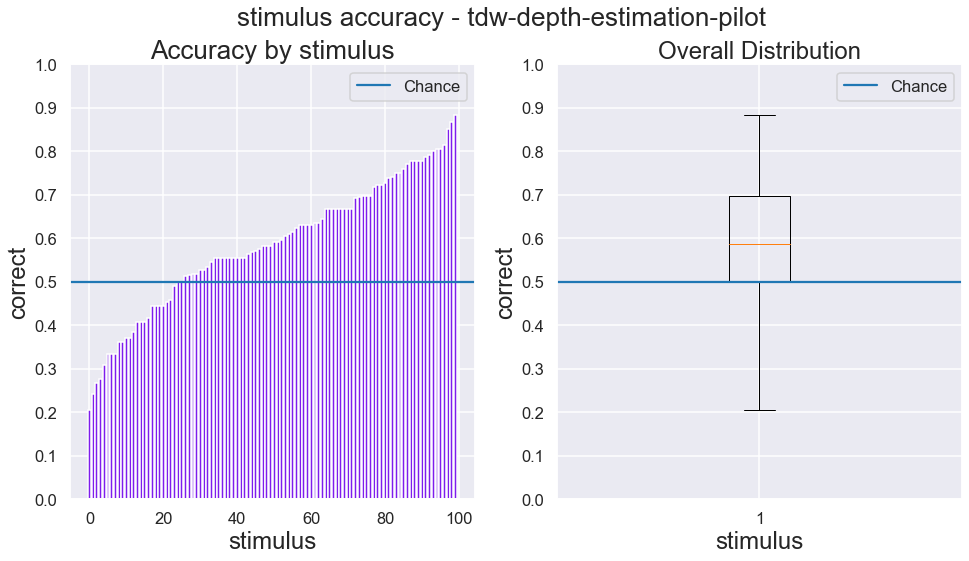

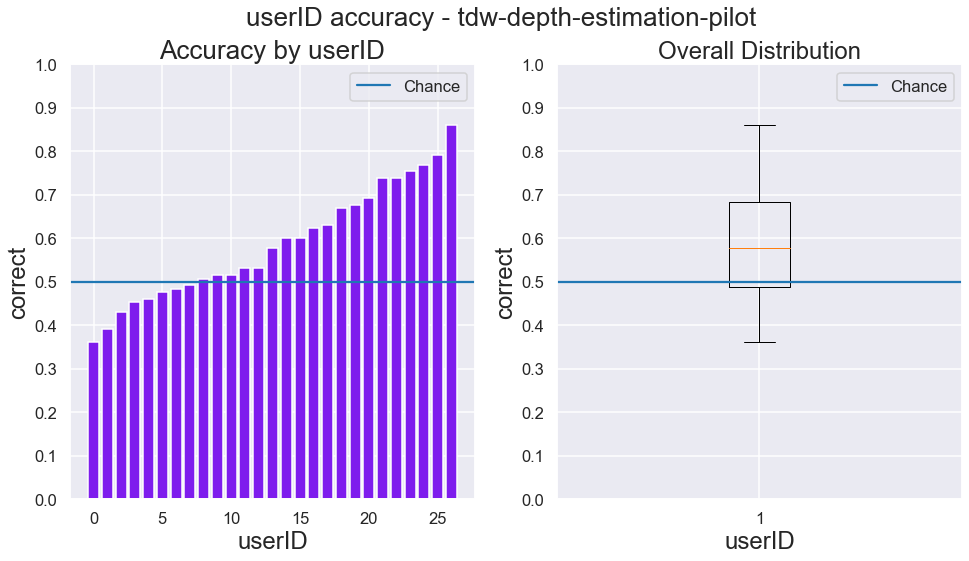

In [99]:
def plot_distributions(df, population="stimulus", target="correct", color="random"):
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    pop = df.groupby(population)[target].mean()
    sorted_pop_means = pop.sort_values()
    ax1.bar(range(len(pop)), sorted_pop_means, color=color)
    ax1.set_xlabel(population, fontsize=24)
    ax1.set_ylabel(target, fontsize=24)
    ax1.set_yticks(np.arange(0, 1.1, .1))
    ax1.axhline(y=0.5, label="Chance")
    ax1.set_ylim(0, 1)
    ax1.legend()
    
    ax2.boxplot(pop)
    ax2.set_xlabel(population, fontsize=24)
    ax2.set_ylabel(target, fontsize=24)
    ax2.set_yticks(np.arange(0, 1.1, .1))
    ax2.set_ylim(0, 1)
    
    ax1.set_title(f"Accuracy by {population}", fontsize=26)
    ax2.set_title("Overall Distribution", fontsize=24)
    plt.suptitle(f"{population} accuracy - {experimentName}")
    
    plt.axhline(y=0.5, label="Chance")
    plt.legend()
    plt.show()

if dataset in SYNTHETIC_DATASETS:
    color = random_hex()
    plot_distributions(df, population="stimulus", color=color)
    plot_distributions(df, population="userID", color=color)


In [100]:
def l2_dist(x1, x2):
    diffs = [(x1[0] - x2[0]) ** 2, (x1[1] - x2[1]) ** 2]
    return np.sqrt(np.sum(diffs))

def l1_dist(x1, x2):
    diffs = [np.abs(x1[0] - x2[0]), np.abs(x1[1] - x2[1])]
    return np.sqrt(np.sum(diffs))

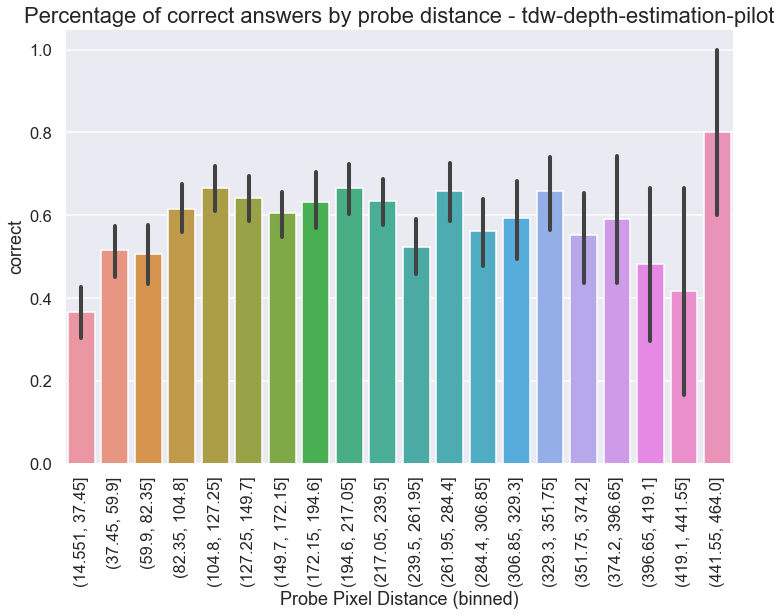

In [101]:
df["probe_distance"] = df["probe_locations"].apply(lambda x: l2_dist(x[0], x[1]))

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=pd.cut(df["probe_distance"], 20), y=df["correct"])
plt.xlabel("Probe Pixel Distance (binned)")
plt.xticks(range(20), rotation=90)
plt.title(f"Percentage of correct answers by probe distance - {experimentName}", fontsize=22)
plt.show()

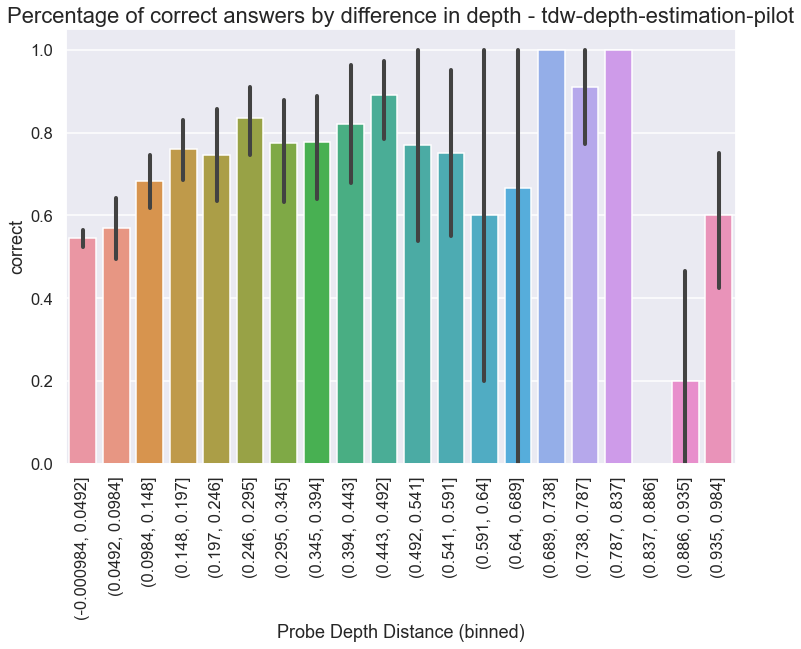

In [102]:
def replace(l, v1, v2):
    """
    replace all values (`v1`) with `v2` in a list `l` 
    """
    for i in range(len(l)):
        if l[i] == v1:
            l[i] = v2
    return l

if dataset in SYNTHETIC_DATASETS:
    df["gtDepths"] = df["gtDepths"].apply(lambda x: replace(x, None, 1))
    df["depth_distance"] = df["gtDepths"].apply(lambda x: np.sqrt((x[0] - x[1]) ** 2))
    fig, ax = plt.subplots(figsize=(12,8))
    sns.barplot(x=pd.cut(df["depth_distance"], 20), y=df["correct"])
    plt.xlabel("Probe Depth Distance (binned)")
    plt.xticks(range(20), rotation=90)
    plt.title(f"Percentage of correct answers by difference in depth - {experimentName}", fontsize=22)
    plt.show()

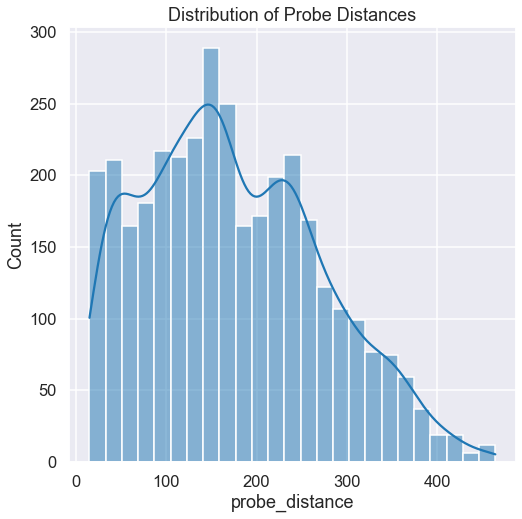

In [103]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df["probe_distance"], kde=True, ax=ax)
plt.title("Distribution of Probe Distances")
plt.show()

In [104]:
def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results

Resulting parameters: 
------------------------------
const             0.051121
probe_distance    0.000148
dtype: float64


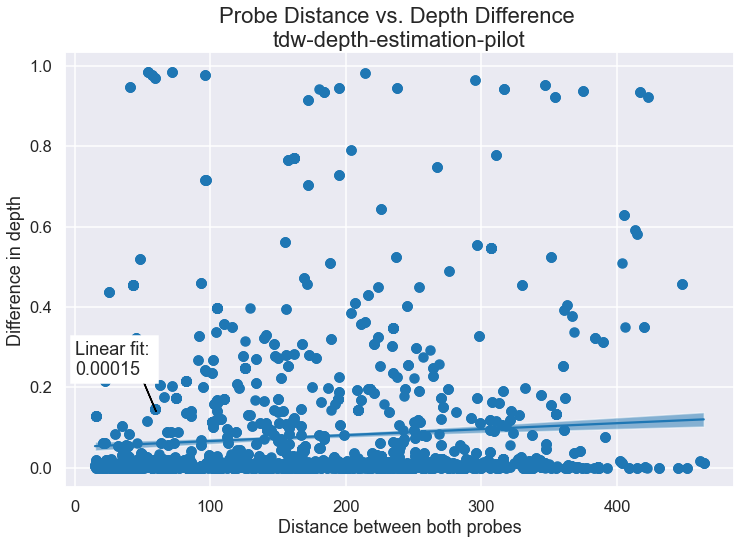

In [105]:
if dataset in SYNTHETIC_DATASETS:
    fig, ax = plt.subplots(figsize=(12, 8))


    fit_result = simple_regplot(df["probe_distance"], df["depth_distance"], ax=ax)
    print("Resulting parameters: \n------------------------------")
    print(fit_result.params)
    plt.title(f"Probe Distance vs. Depth Difference \n{experimentName}", fontsize=22)
    plt.xlabel("Distance between both probes")
    plt.ylabel("Difference in depth")

    plt.text(0.23, 0.23, f"Linear fit: \n{fit_result.params[1]:0.5f}", backgroundcolor="white")
    plt.arrow(50, 0.22, 10, -.08, color="black", )
    plt.show()

analysis to-do:

1. Inter-subject reliability (check consistency between repeats)
2. Check noise ceiling for individual points
3. Check worst trials -- see what the deal is
4. Look at distribution of answers

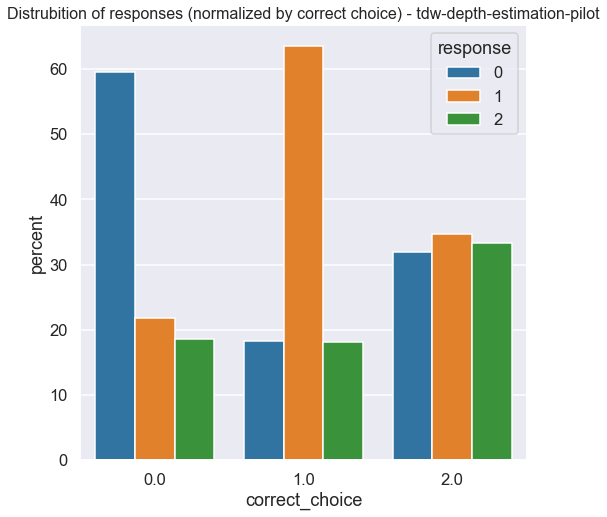

In [106]:
x="correct_choice"
y="response"

fig, ax = plt.subplots(figsize=(8, 8))
(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), x=x,y='percent',hue=y, ax=ax))

plt.title(f"Distrubition of responses (normalized by correct choice) - {experimentName}", fontsize=16)
plt.show()


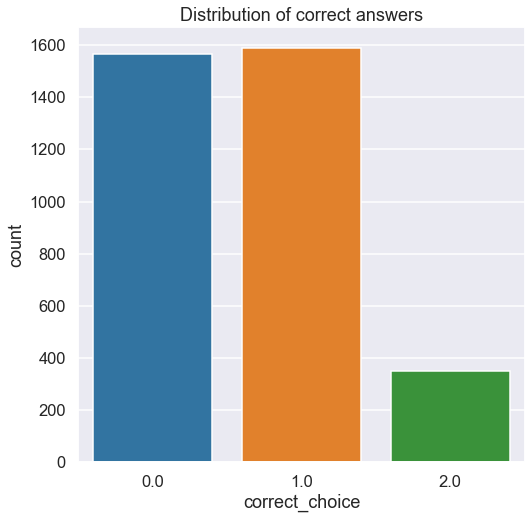

In [107]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(x=df["correct_choice"], ax=ax)
plt.title("Distribution of correct answers")
plt.show()

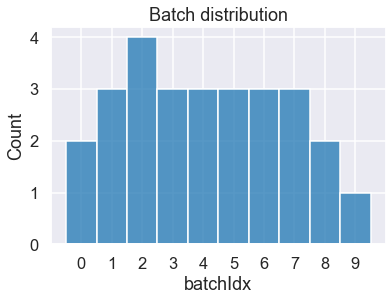

In [108]:
batch_counts = df.groupby("userID")["batchIdx"].mean() # sort of hacky way to get per-
sns.histplot(x=batch_counts, stat="count", binwidth=1, bins=10, discrete=True)
plt.xticks(range(10), range(10))
plt.title("Batch distribution")
plt.show()

## Check most difficult trials

In [109]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    s3_path = url.split(".com/")[1]
    item = bucket.Object(s3_path)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    else:
        return item

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 0 to 4103
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               3506 non-null   object 
 1   imageMetadata     3506 non-null   object 
 2   imageURL          3506 non-null   object 
 3   attentionCheck    3506 non-null   object 
 4   gtDepths          3506 non-null   object 
 5   correctChoice     3506 non-null   float64
 6   probeLocations    3506 non-null   object 
 7   isDuplicate       3506 non-null   object 
 8   batchIdx          3506 non-null   float64
 9   rt                3506 non-null   int64  
 10  index             3506 non-null   float64
 11  stimulus          3506 non-null   object 
 12  response          3506 non-null   object 
 13  correct           3506 non-null   object 
 14  probe_locations   3506 non-null   object 
 15  correct_choice    3506 non-null   float64
 16  choices           3506 non-null   object 


In [111]:
def random_color():
    r = lambda: np.random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

def plot_probe_locations(ax, df, url, probe_size=10):
    trials = df.loc[df["imageURL"] == url]
    probe_locations = set([tuple(((x[0][0], x[0][1]), (x[1][0], x[1][1]))) for x in trials["probeLocations"]])
    for i, probe_pair in enumerate(probe_locations):
        color = random_color()
        probe_left = plt.Circle(probe_pair[0], probe_size, color=color)
        probe_right = plt.Circle(probe_pair[1], probe_size, color=color)
        
        offset = probe_size // 2
        ax.add_patch(probe_left)
        ax.add_patch(probe_right)
        ax.text(probe_pair[0][0] - offset, probe_pair[0][1] + offset, str(i), fontsize=16) 
        ax.text(probe_pair[1][0] - offset, probe_pair[1][1] + offset, str(i), fontsize=16) 
        
    return ax

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# plt.axis("off")
# ax.imshow(img)
# ax = plot_probe_locations(ax, df, "https://mlve-v1.s3.us-east-2.amazonaws.com/hypersim_v2/images/image_090.png")
# plt.show()

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_009.png


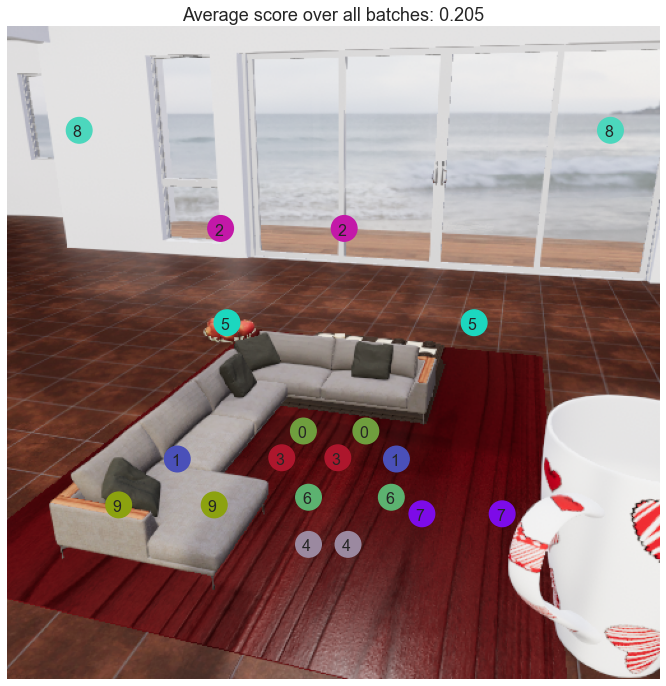

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_058.png


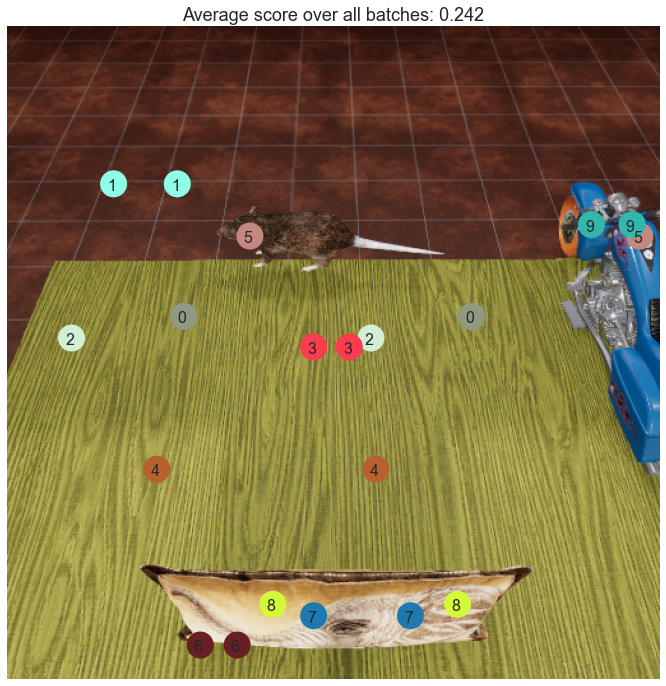

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_092.png


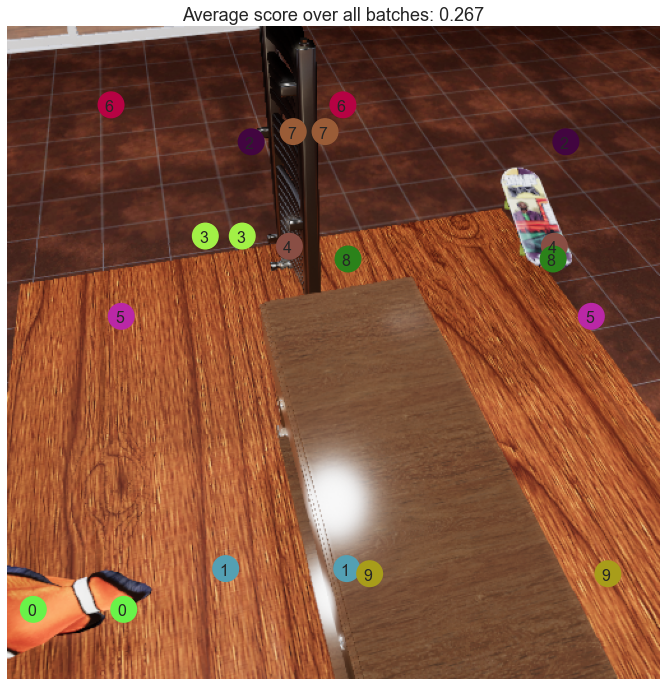

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_053.png


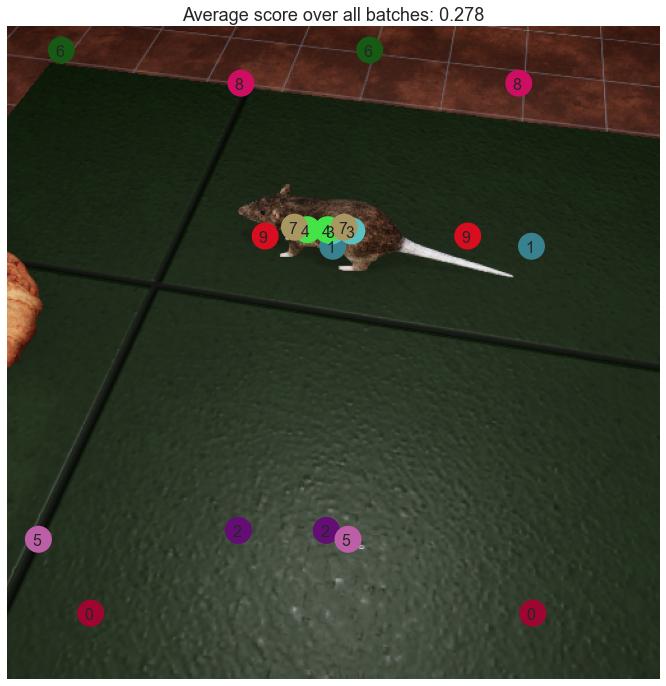

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_007.png


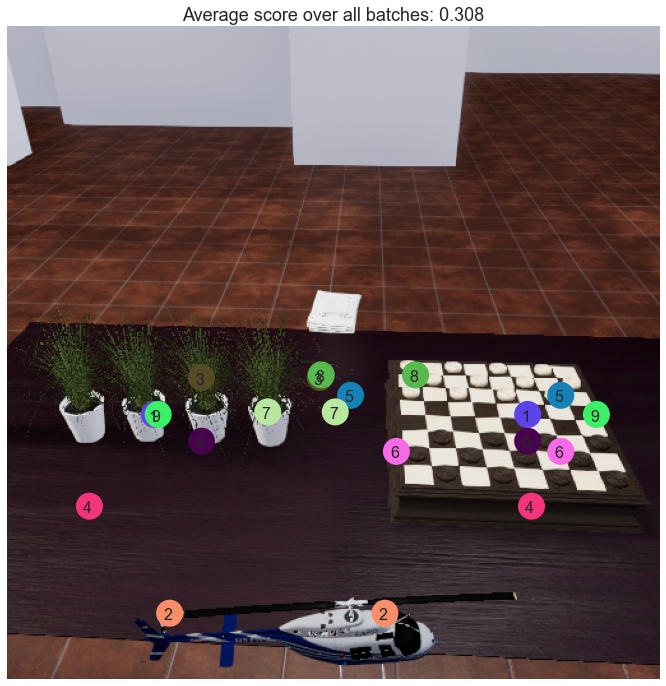

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_078.png


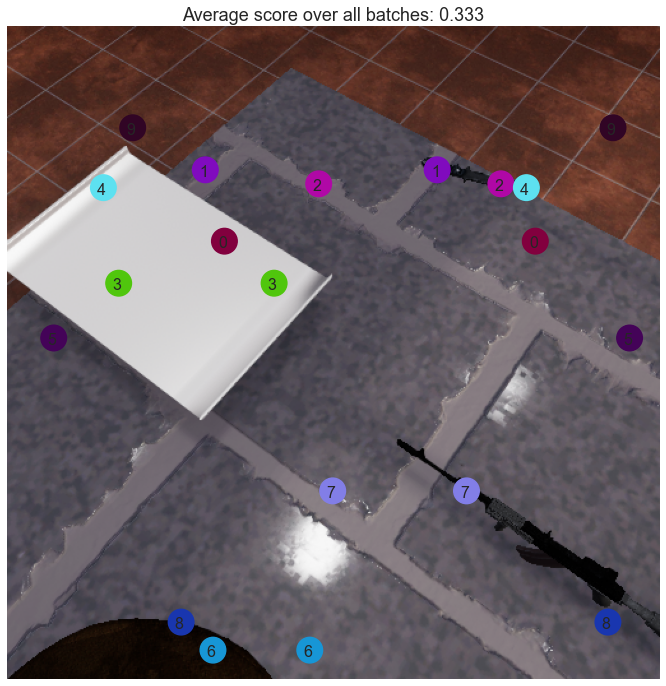

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_074.png


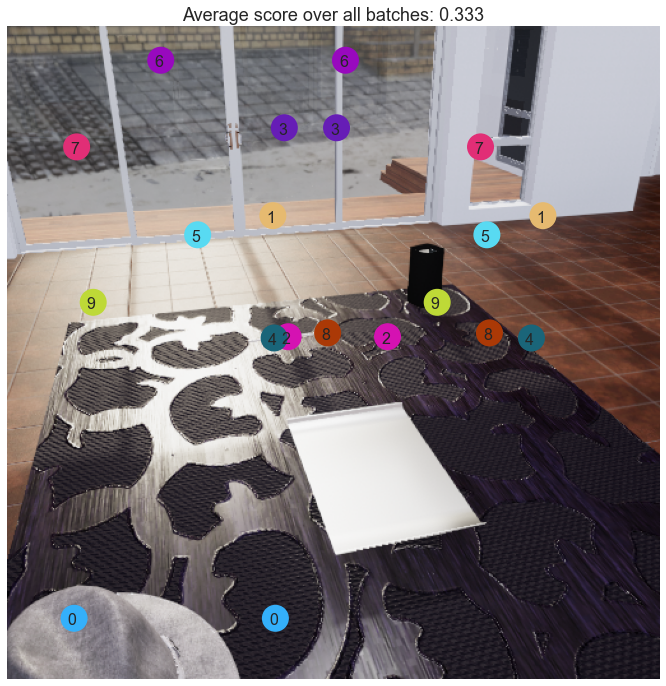

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_079.png


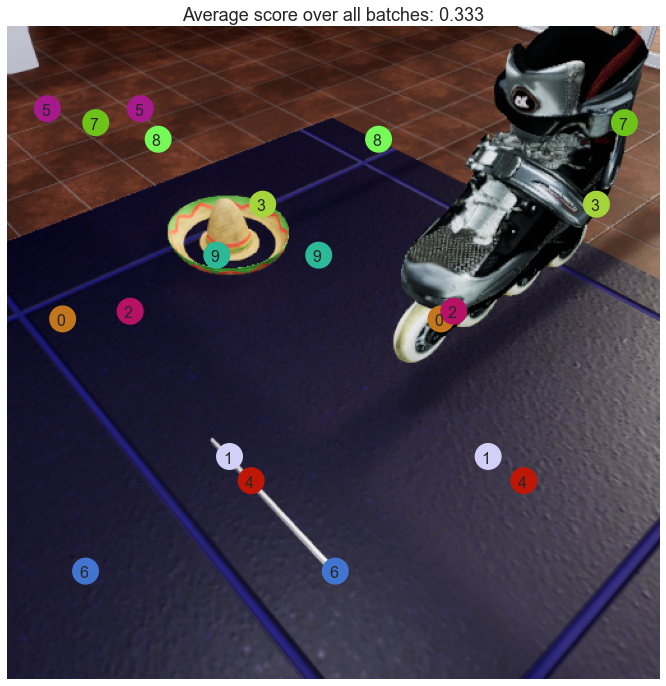

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_051.png


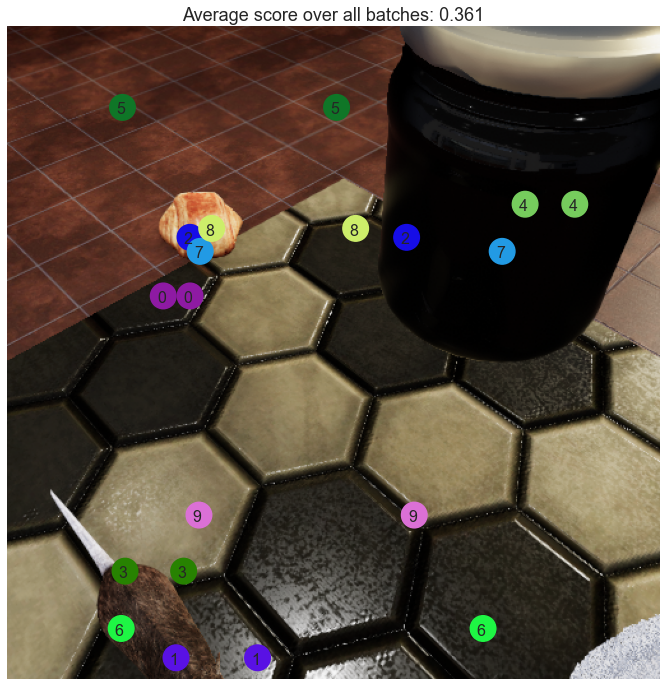

https://mlve-v1.s3.us-east-2.amazonaws.com/tdw/images/image_025.png


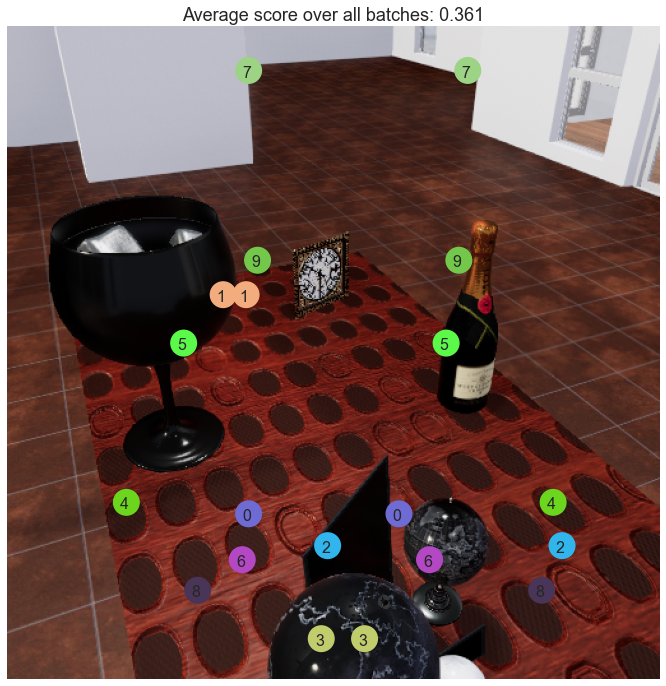

In [112]:
if dataset in SYNTHETIC_DATASETS:
    trials_ranked = df.groupby("stimulus")["correct"].mean()
    trials_ranked = trials_ranked.sort_values()
    
    for i in range(10):
        url = str(trials_ranked.index[i])
        print(url)
        img = download_from_s3(url)
        fig, ax = plt.subplots(1, 1, figsize=(12,12))
        plt.axis("off")
        ax.imshow(np.array(img), cmap="gray")
        ax = plot_probe_locations(ax, df, url)
        score = trials_ranked[i]
        
        plt.title(f"Average score over all batches: {score:0.3f}")
        plt.show()

## Check intra-user consistency

In [113]:
repeat_trials = df.loc[df["isDuplicate"] == True]

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3515 entries, 22 to 4113
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               3515 non-null   object 
 1   imageMetadata     3515 non-null   object 
 2   imageURL          3515 non-null   object 
 3   attentionCheck    3515 non-null   object 
 4   gtDepths          3515 non-null   object 
 5   correctChoice     3515 non-null   float64
 6   probeLocations    3515 non-null   object 
 7   isDuplicate       3515 non-null   object 
 8   batchIdx          3515 non-null   float64
 9   rt                3515 non-null   int64  
 10  index             3515 non-null   float64
 11  stimulus          3515 non-null   object 
 12  response          3515 non-null   object 
 13  correct           3515 non-null   object 
 14  probe_locations   3515 non-null   object 
 15  correct_choice    3515 non-null   float64
 16  choices           3515 non-null   object 

# Measurement Noise

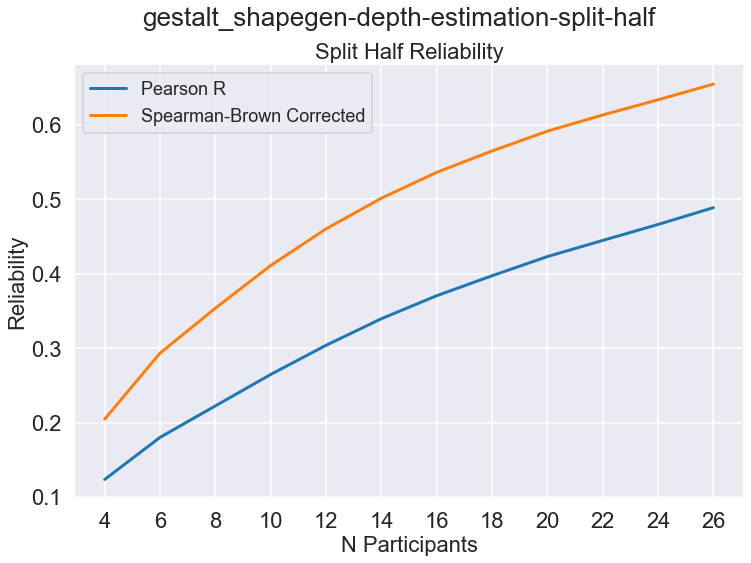

In [115]:
# Split data by user
# For each trial correlate half and half splits
from scipy.stats import pearsonr, sem

def calculate_splithalf(split_num):
    """
    split_num: int: number of participants to sample for each half (ie; if split_num is 5, you choose 5 people for group A and 5 for group B)
    """
    trials = [x[1].values[:27] for x in df.groupby("imageURL")["correct"]]
    trials = np.stack(trials, axis=0) # Gives us a (n_trials, m_participants) array of errors (in our case [100, 38])

    n_participants = trials.shape[1]
    
    pearson_rs = []
    spb_rs = [] # Spearman-Brown corrected Pearson R values
    p_vals = []

    # Take 1000 random splits of participants
    splits = 1000

    for i in range(splits):
        idxs = np.random.choice(range(n_participants), split_num * 2, replace=False)
        a_idxs, b_idxs = np.split(idxs, 2)
        
        a_errs = trials[:, a_idxs].mean(axis=1) # average errors across images
        b_errs = trials[:, b_idxs].mean(axis=1)

        stat, p_val = pearsonr(a_errs, b_errs)
        p_vals.append(p_val)
        pearson_rs.append(stat)
        
        # Spearman-Brown correction = (n*p)/(1 + (n-1)*p) 
        # For split-half n=2 tests
        spb_rs.append((2 * stat) / (1 + stat))

#     print(f"Testing split of {split_num} participants against remainder of population."\
#           f"\nR\t=\t{np.mean(reliabilities)},"\
#           f"\nStd Err\t=\t{sem(reliabilities)}"
#           f"\nP-value\t=\t{np.mean(p_vals)}")
    
    return np.mean(pearson_rs), np.mean(spb_rs)

fig = plt.figure(figsize=(12,8))
rs = []
spbs = []
nparticipants = 14
split_nums = list(range(2, nparticipants))
for split_num in split_nums:
    r, spb = calculate_splithalf(split_num)
    spbs.append(spb)
    rs.append(r)

plt.yticks(fontsize=22)
plt.xticks(range(2, nparticipants), [n * 2 for n in split_nums], fontsize=22)
plt.plot(split_nums, rs, lw=3, label="Pearson R")
plt.plot(split_nums, spbs, lw=3, label="Spearman-Brown Corrected")
plt.xlabel("N Participants", fontsize=22)
plt.ylabel("Reliability", fontsize=22)
plt.legend(fontsize=18)
plt.title("Split Half Reliability", fontsize=22)
plt.suptitle(f"{experimentName}")
plt.show()